# Imports

In [1]:
import os
import csv
import sys 
import torch


from openmm import unit 
from tqdm import tqdm


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from energies import MoleculeFromSMILES_XTB
from utils import logmeanexp

/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/__init__.py:61: UserWarning: Dependency not satisfied, torchani.data will not be available
  warnings.warn("Dependency not satisfied, torchani.data will not be available")


# Constants

In [2]:
input_file = '../database.txt'
batch_size = 32
kB = unit.BOLTZMANN_CONSTANT_kB.value_in_unit(unit.hartree/unit.kelvin)
beta=1/(kB*298.15)
hartree_to_kcal = 627.503
T = 298.15

In [3]:
molecules_smiles = {}
with open(input_file, 'r') as infile:
    reader = csv.reader(infile, delimiter=';')
    for row in reader:
        if row[0].startswith('#'):
            continue  # Skip header or comment lines
        smiles = row[1]
        experimental_val = row[3]
        experimental_uncertainty = row[4]
        molecules_smiles[smiles] = experimental_val, experimental_uncertainty

In [4]:
results_dict = {}

In [ ]:
for k, v in molecules_smiles.items():
    v_energy = MoleculeFromSMILES_XTB(k, temp=T, solvate=False)
    s_energy = MoleculeFromSMILES_XTB(k, temp=T, solvate=True)
    ground_truth = float(v[0])
    uncertainty = float(v[1])

    default_ta_vals = v_energy.rd_conf.get_freely_rotatable_tas_values()

    torsions = v_energy.tas
    if len(torsions) == 0:
        print('No torsions found for {}'.format(k))
        continue
    n = len(torsions)

    distr = torch.distributions.VonMises(torch.tensor([0.0]*n), torch.tensor([4.0]*n))
    def calc_fed(energies):
        en = energies*beta
        factor = hartree_to_kcal * kB * T 
        free_energy = -logmeanexp(-en) * factor
        return free_energy

    num_points = 10000
    # create a tensor to store the energies
    v_energies = torch.zeros(num_points*batch_size)
    s_energies = torch.zeros(num_points*batch_size)
    start = 0
    end = batch_size
    for i in tqdm(range(num_points)):
        batch = distr.sample((batch_size,))
        v_energies[start:end] = v_energy.energy(batch) 
        s_energies[start:end] = s_energy.energy(batch)

        if (i+1) % 25 == 0:
            print('Batch {}/{}'.format(i+1, num_batches))
            v_free_energy = calc_fed(v_energies[:end])
            s_free_energy = calc_fed(s_energies[:end])
            fed = s_free_energy - v_free_energy
            print('Error for {}: {}'.format(k, fed - ground_truth))

        start = end
        end += batch_size

    v_energies *= beta
    s_energies *= beta

    factor = hartree_to_kcal * kB * T 
    v_free_energy = -logmeanexp(-v_energies) * factor
    s_free_energy = -logmeanexp(-s_energies) * factor

    fed = s_free_energy - v_free_energy 
    results_dict[k] = fed, ground_truth, uncertainty
    print('Error for {}: {}'.format(k, fed - ground_truth))


In [35]:
# s_energies[:6250*32]
(s_energies != 0 ).sum(), len(v_energies)

(tensor(261887), 320000)

In [36]:
s_energies = s_energies[:261887]
v_energies = v_energies[:261887]

In [51]:
(calc_fed(s_energies) - calc_fed(v_energies)) - ground_truth, ground_truth

(tensor(-1.8791), -2.49)

In [118]:
# calculate the running error per 5 samples so :5, :10, :15 etc
# calculate the error for each of these and plot them
feds = []
step = 32
for i in range(step, 261887, step):
    fed = calc_fed(s_energies[:i]) - calc_fed(v_energies[:i])
    feds.append(fed)


In [119]:
feds[-10:]

[tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691),
 tensor(-4.3691)]

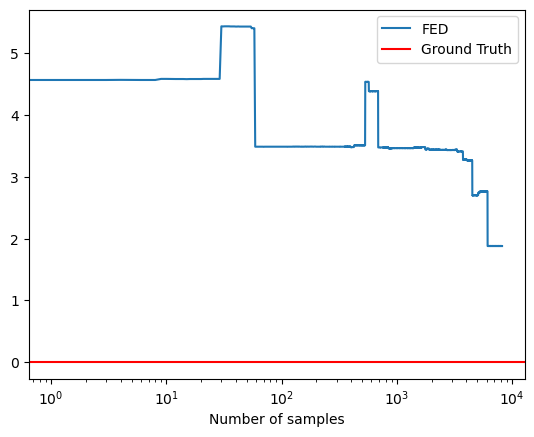

In [123]:
import matplotlib.pyplot as plt

plt.plot(np.abs(np.array(feds) - ground_truth))

# add the ground truth value
plt.axhline(y=0, color='r', linestyle='-')

# increase x scale by step size (just visual), 
plt.xticks(range(0, len(feds), 1), range(0, len(feds)*step, step))

plt.xscale('log')
plt.xlabel(f'Number of samples')
plt.legend(['FED', 'Ground Truth'])
plt.show()


In [ ]:
# with open(f'../fed_results/rotation_fed_n={n}.csv', 'w') as f:
#     f.write('SMILES,experimental_val,fed_Z_learned,fed_Z,fed_Z_lb,timestamp\n')
#     for k, v in results_dict.items():
#         f.write(f'{k},{v[1]} ± {v[2]},0 ± 0,{v[0]} ± 0,0 ± 0,23-08-2024 02-47\n')

In [140]:
import torch
import random

# Define the Metropolis criterion
def metropolis_acceptance(energy_diff, beta):
    rand = random.random()
    acceptance = rand < torch.exp(-beta * energy_diff).item()
    return acceptance

# Function to propose new torsion angles
def propose_new_torsion(torsions, step_size, batch_size):
    return torsions + torch.randn(batch_size, *torsions.shape[1:]) * step_size

batch_size = 50  # Define batch size for the proposal

# Initialize variables
v_energies = []
s_energies = []
torsions = torch.tensor(v_energy.rd_conf.get_freely_rotatable_tas_values()).unsqueeze(0).repeat(batch_size, 1).expand(batch_size, -1)

# Set the MC parameters
num_steps = 10000
step_size = 0.1  # Adjust step size for proposal moves
feds = []
for i in range(num_steps):
    # Propose new torsion angles in batches
    new_torsions_batch = propose_new_torsion(torsions, step_size, batch_size)
    
    # Calculate energies for the proposed torsions
    v_energy_new_batch = v_energy.energy(new_torsions_batch)
    s_energy_new_batch = s_energy.energy(new_torsions_batch)
    
    # Calculate the difference in energies
    v_energy_current = v_energy.energy(torsions)
    s_energy_current = s_energy.energy(torsions)
    
    
    energy_diff_v_batch = v_energy_new_batch - v_energy_current
    energy_diff_s_batch = s_energy_new_batch - s_energy_current
    # Accept or reject the new torsions based on the Metropolis criterion for each in the batch
    for j in range(batch_size):
        if metropolis_acceptance(energy_diff_v_batch[j], beta):
            torsions[j] = new_torsions_batch[j]
            v_energies.append(v_energy_new_batch[j])            
        if metropolis_acceptance(energy_diff_s_batch[j], beta):
            s_energies.append(s_energy_new_batch[j])
    
    # Print progress and intermediate results
    if (i + 1) % 25 == 0:
        print(f'Step {i + 1}/{num_steps}')
        v_free_energy = calc_fed(torch.tensor(v_energies))
        s_free_energy = calc_fed(torch.tensor(s_energies))
        fed = s_free_energy - v_free_energy
        feds.append(fed)
        print('Error for {}: {}'.format(k, fed - ground_truth))

# Final free energy calculation
v_free_energy = calc_fed(torch.tensor(v_energies))
s_free_energy = calc_fed(torch.tensor(s_energies))
fed = s_free_energy - v_free_energy
results_dict[k] = fed, ground_truth, uncertainty
print('Final Error for {}: {}'.format(k, fed - ground_truth))

/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/nfs/homedirs/ralev/miniconda3/envs/gfn-energy/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not inst

Step 25/10000
Error for  CCCCCC(=O)OC: -1.4650781154632568
Step 50/10000
Error for  CCCCCC(=O)OC: -1.4084374904632568
Step 75/10000
Error for  CCCCCC(=O)OC: -1.3869531154632568
Step 100/10000
Error for  CCCCCC(=O)OC: -1.3732812404632568
Step 125/10000
Error for  CCCCCC(=O)OC: -1.3713281154632568
Step 150/10000
Error for  CCCCCC(=O)OC: -1.3654687404632568
Step 175/10000
Error for  CCCCCC(=O)OC: -1.3674218654632568
Step 200/10000
Error for  CCCCCC(=O)OC: -1.3674218654632568
Step 225/10000
Error for  CCCCCC(=O)OC: -1.3576562404632568
Step 250/10000
Error for  CCCCCC(=O)OC: -1.3537499904632568
Step 275/10000
Error for  CCCCCC(=O)OC: -1.3478906154632568
Step 300/10000
Error for  CCCCCC(=O)OC: -1.3439843654632568
Step 325/10000
Error for  CCCCCC(=O)OC: -1.3322656154632568
Step 350/10000
Error for  CCCCCC(=O)OC: -1.3303124904632568
Step 375/10000
Error for  CCCCCC(=O)OC: -1.3244531154632568
Step 400/10000
Error for  CCCCCC(=O)OC: -1.3205468654632568
Step 425/10000
Error for  CCCCCC(=O)OC: -1.

KeyboardInterrupt: 

In [141]:
len(v_energies), len(s_energies)

(164891, 169495)

In [144]:
# save both as numpy arrays
import numpy as np
np.save('v_energies_mc.npy', np.array([x.cpu() for x in v_energies]))
np.save('s_energies_mc.npy', np.array([x.cpu() for x in s_energies]))

In [151]:
len(v_energies), len(s_energies)

(164891, 169495)

In [166]:
# calculate the running error per 5 samples so :5, :10, :15 etc
# calculate the error for each of these and plot them
feds = []
step = 32
s_energies = torch.tensor(s_energies)
v_energies = torch.tensor(v_energies)
for i in range(step, 164891, step):
    fed = calc_fed(s_energies[:i]) - calc_fed(v_energies[:i])
    feds.append(fed)

/tmp/ipykernel_2663428/2804702199.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_energies = torch.tensor(s_energies)
/tmp/ipykernel_2663428/2804702199.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_energies = torch.tensor(v_energies)


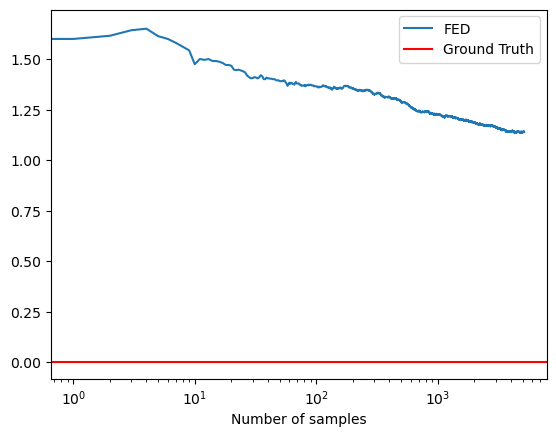

In [167]:
import matplotlib.pyplot as plt

plt.plot(np.abs(np.array(feds) - ground_truth))

# add the ground truth value
plt.axhline(y=0, color='r', linestyle='-')

# increase x scale by step size (just visual), 
plt.xticks(range(0, len(feds), 1), range(0, len(feds)*step, step))

plt.xscale('log')
plt.xlabel(f'Number of samples')
plt.legend(['FED', 'Ground Truth'])
plt.show()
